# Credit Card Fraud Detection - Enhanced Modeling

## HỌ VÀ TÊN: Cao Tấn Hoàng Huy
## MSSV: 23127051

In [1]:
# Khai báo các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Setup for reproducibility
np.random.seed(42)

## Load preprocessed data



In [2]:
# Try to load preprocessed data from memory, or process from scratch
try:
    # Check if data exists from previous notebook
    print("Checking for preprocessed data from previous notebook...")
    print(f"X_train_scaled: {X_train_scaled.shape}")
    print(f"X_test_scaled:  {X_test_scaled.shape}")
    print(f"X_train_poly:   {X_train_poly.shape}")
    print(f"X_test_poly:    {X_test_poly.shape}")
    print(f"y_train:        {y_train.shape}")
    print(f"y_test:         {y_test.shape}")
    print(f"✓ Preprocessed data loaded from previous notebook successfully!")
    
except NameError:
    print("Preprocessed data not found in memory. Loading and processing from CSV...")
    print("This will take a moment...\n")
    
    # ========== LOAD DATA FROM CSV ==========
    print("Step 1/5: Loading data from CSV...")
    with open('../data/creditcard.csv', 'r') as f:
        lines = f.readlines()
    
    header = lines[0].strip().replace('"', '').split(',')
    data_list = []
    
    for i, line in enumerate(lines[1:], 1):
        try:
            line = line.strip()
            if not line:
                continue
            values = line.split(',')
            float_values = [float(val.strip().strip('"')) for val in values]
            if len(float_values) == 31:
                data_list.append(float_values)
        except:
            pass
    
    data = np.array(data_list, dtype=np.float64)
    column_names = header
    print(f"   Data loaded: {data.shape}")
    
    # ========== SPLIT FEATURES AND TARGET ==========
    print("Step 2/5: Splitting features and target...")
    X = data[:, :-1]  # All columns except last
    y = data[:, -1]   # Last column (Class)
    print(f"   X: {X.shape}, y: {y.shape}")
    
    # ========== TRAIN-TEST SPLIT ==========
    print("Step 3/5: Train-test split (80-20)...")
    np.random.seed(42)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(0.8 * n_samples)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    print(f"   Train: {X_train.shape}, Test: {X_test.shape}")
    
    # ========== STANDARDIZATION ==========
    print("Step 4/5: Standardizing features...")
    # Compute mean and std from training data
    train_mean = np.mean(X_train, axis=0)
    train_std = np.std(X_train, axis=0)
    train_std[train_std == 0] = 1.0  # Avoid division by zero
    
    # Apply to both train and test
    X_train_scaled = (X_train - train_mean) / train_std
    X_test_scaled = (X_test - train_mean) / train_std
    print(f"   Scaled data ready")
    
    # ========== CREATE POLYNOMIAL FEATURES ==========
    print("Step 5/5: Creating polynomial features (degree 2)...")
    # We'll create a simple version with key features only
    n_features = X_train_scaled.shape[1]
    
    # Select top features (Amount, V1-V10 as example)
    key_features_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 28]  # Time, V1-V10, Amount
    X_train_key = X_train_scaled[:, key_features_idx]
    X_test_key = X_test_scaled[:, key_features_idx]
    
    # Create polynomial: [original features, squared features, interaction terms]
    X_train_squared = X_train_key ** 2
    X_test_squared = X_test_key ** 2
    
    X_train_poly = np.hstack([X_train_scaled, X_train_squared])
    X_test_poly = np.hstack([X_test_scaled, X_test_squared])
    
    print(f"   Polynomial features: {X_train_poly.shape}")
    
    print("\n✓ All data loaded and preprocessed successfully!")
    print(f"\nFinal shapes:")
    print(f"  X_train_scaled: {X_train_scaled.shape}")
    print(f"  X_test_scaled:  {X_test_scaled.shape}")
    print(f"  X_train_poly:   {X_train_poly.shape}")
    print(f"  X_test_poly:    {X_test_poly.shape}")
    print(f"  y_train:        {y_train.shape}")
    print(f"  y_test:         {y_test.shape}")

# Class distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(f"\nClass distribution in training:")
for cls, count in zip(unique_train, counts_train):
    pct = (count / len(y_train)) * 100
    label = "Normal" if cls == 0 else "Fraud"
    print(f"  {label}: {count:>6,} ({pct:>5.2f}%)")

imbalance_ratio = counts_train[0] / counts_train[1] if len(counts_train) == 2 else None
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

Checking for preprocessed data from previous notebook...
Preprocessed data not found in memory. Loading and processing from CSV...
This will take a moment...

Step 1/5: Loading data from CSV...
   Data loaded: (284807, 31)
Step 2/5: Splitting features and target...
   X: (284807, 30), y: (284807,)
Step 3/5: Train-test split (80-20)...
   Train: (227845, 30), Test: (56962, 30)
Step 4/5: Standardizing features...
   Scaled data ready
Step 5/5: Creating polynomial features (degree 2)...
   Polynomial features: (227845, 42)

✓ All data loaded and preprocessed successfully!

Final shapes:
  X_train_scaled: (227845, 30)
  X_test_scaled:  (56962, 30)
  X_train_poly:   (227845, 42)
  X_test_poly:    (56962, 42)
  y_train:        (227845,)
  y_test:         (56962,)

Class distribution in training:
  Normal: 227,458 (99.83%)
  Fraud:    387 ( 0.17%)
  Imbalance ratio: 587.7:1


# THREE MODELS IMPLEMENTATION

## 1. Linear Regression 

### THUẬT TOÁN LINEAR REGRESSION

**Mô tả:** Linear Regression dự đoán giá trị liên tục bằng cách tìm đường thẳng (hoặc hyperplane) fit tốt nhất với dữ liệu.

**Công thức chính:**
```
ŷ = X · w + b
```
Trong đó:
- `X`: Ma trận features (m samples × n features)
- `w`: Vector weights (n features)
- `b`: Bias (scalar)
- `ŷ`: Predictions

---

#### **BƯỚC 1: INITIALIZATION (Khởi tạo parameters)**

```python
# Xavier Initialization cho numerical stability
limit = sqrt(6.0 / (n_features + 1))
weights = random.uniform(-limit, limit, n_features)
bias = 0.0
```

**Mục đích:** 
- Random weights trong khoảng hợp lý
- Tránh exploding/vanishing gradients
- Xavier initialization phù hợp với linear activation

---

#### **BƯỚC 2: FORWARD PASS (Tính predictions)**

```python
# Vectorized computation - NO LOOPS
y_pred = X @ weights + bias
```

**Giải thích:**
- `X @ weights`: Matrix multiplication (m×n) @ (n,) = (m,)
- `+ bias`: Broadcasting - cộng bias vào mọi prediction
- Kết quả: Array (m,) chứa predictions cho m samples

**Ví dụ:**
```
X.shape = (1000, 30)  # 1000 samples, 30 features
weights.shape = (30,)
y_pred.shape = (1000,)  # 1000 predictions
```

---

#### **BƯỚC 3: COMPUTE COST (Tính loss function)**

**Loss Function: MSE + L2 Regularization**

```python
# Mean Squared Error
squared_error = (y_pred - y) ** 2
mse = sum(squared_error) / (2 * m)

# L2 Regularization (Ridge)
l2_penalty = (λ / 2) * sum(weights ** 2)

# Total Cost
cost = mse + l2_penalty
```

**Vectorized với einsum (hiệu quả hơn):**
```python
error = y_pred - y
squared_error = np.einsum('i,i->', error, error)  # Dot product
mse = squared_error / (2 * m)
l2_penalty = (λ / 2) * np.einsum('i,i->', weights, weights)
cost = mse + l2_penalty
```

**Tại sao L2 Regularization?**
- Tránh overfitting
- Penalize weights có giá trị lớn
- Giúp model generalize tốt hơn

---

#### **BƯỚC 4: BACKWARD PASS (Tính gradients)**

**Gradient của Cost theo weights và bias:**

```python
error = y_pred - y  # Shape: (m,)

# Gradient của weights
dw = (1/m) * X.T @ error + λ * weights
# Giải thích: 
# - X.T @ error: (n, m) @ (m,) = (n,) - gradient từ MSE
# - λ * weights: gradient từ L2 regularization

# Gradient của bias
db = (1/m) * sum(error)
```

**Vectorized với einsum:**
```python
dw = (1/m) * np.einsum('ij,i->j', X, error) + λ * weights
# 'ij,i->j' nghĩa: sum over i (samples), keep j (features)
```

**Công thức toán học:**
```
∂J/∂w = (1/m) * X^T · (ŷ - y) + λ · w
∂J/∂b = (1/m) * sum(ŷ - y)
```

---

#### **BƯỚC 5: PARAMETER UPDATE (Gradient Descent)**

```python
# Update weights và bias theo hướng ngược với gradient
weights = weights - learning_rate * dw
bias = bias - learning_rate * db
```

**Mục đích:**
- Di chuyển weights theo hướng giảm cost
- Learning rate (α) điều chỉnh tốc độ học
- Nếu α quá lớn → overshooting, α quá nhỏ → học chậm

**Ví dụ:**
```
weights = [0.5, -0.3, 0.8]
dw = [0.1, -0.05, 0.2]
learning_rate = 0.01

weights_new = [0.5 - 0.01*0.1, -0.3 - 0.01*(-0.05), 0.8 - 0.01*0.2]
            = [0.499, -0.2995, 0.798]
```

---

#### **BƯỚC 6: CONVERGENCE CHECK (Kiểm tra hội tụ)**

```python
if abs(previous_cost - current_cost) < tolerance:
    # Cost không thay đổi nhiều → đã hội tụ
    break
```

**3 điều kiện dừng:**
1. Cost thay đổi < tolerance (đã hội tụ)
2. Đạt max_iterations (tránh chạy vô hạn)
3. Cost tăng liên tục (learning rate quá lớn)

---

#### **BƯỚC 7: PREDICTION (Dự đoán cho dữ liệu mới)**

```python
# Sử dụng weights đã học
y_pred = X_new @ weights + bias

# Convert sang binary cho classification
y_binary = (y_pred >= 0.5).astype(int)
# >= 0.5 → Class 1 (Fraud)
# < 0.5  → Class 0 (Normal)
```

In [3]:
class LinearRegression:
    """
    Linear Regression - Pure NumPy Implementation
    
    VECTORIZATION FEATURES:
    - No for loops for array operations
    - Broadcasting for efficient computation
    - np.linalg for optimized matrix operations
    - Memory-efficient gradient computation
    - Numerical stability with regularization
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, 
                 tolerance=1e-6, regularization_strength=0.01, verbose=False):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.lambda_ = regularization_strength  # L2 regularization
        self.verbose = verbose
        
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.fitted = False
    
    def _compute_cost(self, X, y):
        """
        Compute MSE cost with L2 regularization - FULLY VECTORIZED
        Uses broadcasting and np.einsum for efficiency
        """
        m = X.shape[0]
        
        # Vectorized prediction: y_pred = X @ weights + bias (broadcasting)
        y_pred = X @ self.weights + self.bias
        
        # Vectorized MSE using einsum for efficient squared error
        squared_error = np.einsum('i,i->', (y_pred - y), (y_pred - y))
        mse = squared_error / (2 * m)
        
        # L2 regularization term (vectorized)
        l2_penalty = (self.lambda_ / 2) * np.einsum('i,i->', self.weights, self.weights)
        
        return mse + l2_penalty
    
    def fit(self, X, y):
        """
        Train using Gradient Descent - FULLY VECTORIZED
        NO loops for array operations, only iteration loop
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        m, n = X.shape
        
        # Xavier initialization for numerical stability
        limit = np.sqrt(6.0 / (n + 1))
        self.weights = np.random.uniform(-limit, limit, n)
        self.bias = 0.0
        self.cost_history = []
        
        if self.verbose:
            print(f"Training Linear Regression...")
            print(f"  Samples: {m}, Features: {n}")
            print(f"  Regularization (λ): {self.lambda_}")
        
        prev_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # VECTORIZED Forward pass using broadcasting
            y_pred = X @ self.weights + self.bias  # Shape: (m,)
            
            # VECTORIZED Gradient computation using einsum
            error = y_pred - y  # Shape: (m,)
            
            # Efficient gradient computation
            # dw = (1/m) * X.T @ error + λ * weights
            dw = (1/m) * np.einsum('ij,i->j', X, error) + self.lambda_ * self.weights
            db = (1/m) * np.sum(error)
            
            # VECTORIZED Parameter update
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Cost tracking
            cost = self._compute_cost(X, y)
            self.cost_history.append(cost)
            
            # Convergence check
            if abs(prev_cost - cost) < self.tolerance:
                if self.verbose:
                    print(f"  Converged at iteration {iteration + 1}")
                break
            prev_cost = cost
            
            if self.verbose and (iteration + 1) % 100 == 0:
                print(f"  Iteration {iteration + 1:>4}: Cost = {cost:.6f}")
        
        self.fitted = True
        
        if self.verbose:
            print(f"  Training completed! Final cost: {self.cost_history[-1]:.6f}")
        
        return self
    
    def predict(self, X):
        """Predict - VECTORIZED using broadcasting"""
        if not self.fitted:
            raise ValueError("Model chưa được train. Hãy gọi fit() trước.")
        
        X = np.asarray(X, dtype=np.float64)
        return X @ self.weights + self.bias
    
    def score(self, X, y):
        """Calculate R² score - VECTORIZED"""
        y = np.asarray(y, dtype=np.float64)
        y_pred = self.predict(X)
        
        # Vectorized R² calculation using einsum
        ss_res = np.einsum('i,i->', (y - y_pred), (y - y_pred))
        ss_tot = np.einsum('i,i->', (y - np.mean(y)), (y - np.mean(y)))
        
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

print("Linear Regression implementation completed (fully vectorized)!")

Linear Regression implementation completed (fully vectorized)!


## 2. Logistic Regression

### THUẬT TOÁN LOGISTIC REGRESSION

**Mô tả:** Logistic Regression là thuật toán classification dự đoán xác suất một sample thuộc class 1 (Fraud) sử dụng Sigmoid function.

**Công thức chính:**
```
z = X · w + b
ŷ = σ(z) = 1 / (1 + e^(-z))
```

Trong đó:
- `z`: Linear combination (logits)
- `σ`: Sigmoid function (chuyển z về xác suất 0-1)
- `ŷ`: Xác suất dự đoán (0 = Normal, 1 = Fraud)

---

#### **BƯỚC 1: SIGMOID FUNCTION (Numerical Stability)**

**Công thức:**
```
σ(z) = 1 / (1 + e^(-z))
```

**Implementation:**
```python
# Naive version - CÓ VẤN ĐỀ
sigmoid = 1.0 / (1.0 + np.exp(-z))
# Vấn đề: Nếu z quá lớn (>700) → exp(-z) = 0 → OK
#         Nếu z quá nhỏ (<-700) → exp(-z) = infinity → ERROR!

# Stable version - ĐÚNG
z = np.clip(z, -500, 500)  # Clip trước khi exp
sigmoid = 1.0 / (1.0 + np.exp(-z))
```

**Tại sao Sigmoid?**
- Map giá trị bất kỳ (-∞, +∞) về (0, 1)
- Output có thể hiểu như xác suất
- Smooth, differentiable → dễ tính gradient
- σ'(z) = σ(z) · (1 - σ(z)) (gradient đơn giản)

**Đặc điểm:**
```
σ(0) = 0.5    (ngưỡng quyết định)
σ(+∞) → 1     (chắc chắn là class 1)
σ(-∞) → 0     (chắc chắn là class 0)
```

---

#### **BƯỚC 2: CLASS WEIGHTS (Xử lý Imbalanced Data)**

**Vấn đề:**
- Normal: 284,315 samples (99.83%)
- Fraud: 492 samples (0.17%)
- Model sẽ bias về Normal!

**Giải pháp: Sample Weights**
```python
class_weights = {
    0: 1.0,                    # Normal: weight = 1
    1: 284315 / 492 = 577.7    # Fraud: weight = 577.7
}
```

**Implementation:**
```python
# Tạo sample weights array
sample_weights = np.zeros(m)
for class_label, weight in class_weights.items():
    mask = (y == class_label)  # Boolean mask
    sample_weights[mask] = weight  # Fancy indexing

# Kết quả:
# - Normal samples: weight = 1.0
# - Fraud samples: weight = 577.7
```

**Hiệu quả:**
- Model penalty nhiều hơn khi predict sai Fraud
- Mỗi fraud sample "đóng góp" bằng 577 normal samples
- Cân bằng ảnh hưởng của 2 classes trong loss

---

#### **BƯỚC 3: FORWARD PASS (Tính predictions)**

```python
# Linear combination
z = X @ weights + bias  # Shape: (m,)

# Sigmoid activation
y_pred = sigmoid(z)     # Shape: (m,), values in [0, 1]
```

**Giải thích:**
```
Sample 1: z = 2.5  → σ(2.5) = 0.924  → ~92% Fraud
Sample 2: z = -1.0 → σ(-1.0) = 0.269 → ~27% Fraud
Sample 3: z = 0.1  → σ(0.1) = 0.525  → ~52% Fraud
```

**Decision rule:**
```python
if y_pred >= 0.5: predict Class 1 (Fraud)
else: predict Class 0 (Normal)
```

---

#### **BƯỚC 4: COMPUTE COST (Binary Cross-Entropy + Weights)**

**Loss Function:**
```
J = -1/m * Σ w_i[y_i·log(ŷ_i) + (1-y_i)·log(1-ŷ_i)] + λ/2·||w||²
```

**Giải thích từng phần:**

**4.1. Binary Cross-Entropy:**
```python
# Clip để tránh log(0)
epsilon = 1e-15
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

# Cross-entropy cho từng sample
log_loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
```

**Tại sao công thức này?**
```
Nếu y = 1 (Fraud):
    loss = -log(ŷ)
    - Nếu ŷ = 1 (predict đúng) → loss = 0 (tốt!)
    - Nếu ŷ = 0 (predict sai)  → loss = ∞ (penalty lớn!)

Nếu y = 0 (Normal):
    loss = -log(1 - ŷ)
    - Nếu ŷ = 0 (predict đúng) → loss = 0 (tốt!)
    - Nếu ŷ = 1 (predict sai)  → loss = ∞ (penalty lớn!)
```

**4.2. Weighted Loss:**
```python
# Apply sample weights
weighted_loss = np.einsum('i,i->', sample_weights, log_loss) / m
# 'i,i->' nghĩa: element-wise multiply rồi sum
```

**4.3. L2 Regularization:**
```python
l2_penalty = (λ / 2) * np.einsum('i,i->', weights, weights)
```

**Total Cost:**
```python
cost = weighted_loss + l2_penalty
```

---

#### **BƯỚC 5: BACKWARD PASS (Tính gradients)**

**Gradient computation:**
```python
# Error signal
error = y_pred - y  # Shape: (m,)

# Weighted error (incorporate sample weights)
weighted_error = sample_weights * error  # Element-wise multiply

# Gradients
dw = (1/m) * X.T @ weighted_error + λ * weights
#    ↑ Gradient từ weighted loss  ↑ Gradient từ L2

db = (1/m) * sum(weighted_error)
```

**Vectorized với einsum:**
```python
dw = (1/m) * np.einsum('ij,i->j', X, weighted_error) + λ * weights
```

**Công thức toán học:**
```
∂J/∂w = (1/m) * X^T · (w_sample ⊙ (σ(X·w+b) - y)) + λ·w
∂J/∂b = (1/m) * sum(w_sample ⊙ (σ(X·w+b) - y))
```
Trong đó `⊙` là element-wise multiplication.

---

#### **BƯỚC 6: PARAMETER UPDATE (Gradient Descent)**

```python
weights = weights - learning_rate * dw
bias = bias - learning_rate * db
```

**Adaptive learning rate (optional):**
```python
# Learning rate decay
if iteration % 100 == 0:
    learning_rate *= 0.95  # Giảm 5% mỗi 100 iterations
```

---

#### **BƯỚC 7: CONVERGENCE CHECK**

```python
# Track cost history
cost_history.append(cost)

# Check convergence
if abs(previous_cost - current_cost) < tolerance:
    print(f"Converged at iteration {iteration}")
    break
```

---

#### **BƯỚC 8: PREDICTION**

**8.1. Predict Probabilities:**
```python
# Output xác suất cho cả 2 classes
z = X_new @ weights + bias
prob_fraud = sigmoid(z)         # P(y=1|X)
prob_normal = 1 - prob_fraud    # P(y=0|X)

probabilities = np.column_stack([prob_normal, prob_fraud])
# Shape: (n_samples, 2)
```

**8.2. Predict Classes:**
```python
# Sử dụng threshold (mặc định 0.5)
predictions = (prob_fraud >= threshold).astype(int)

# Có thể điều chỉnh threshold:
threshold = 0.3  # Sensitive hơn với fraud (recall cao hơn)
predictions = (prob_fraud >= 0.3).astype(int)
```

In [4]:
class LogisticRegression:
    """
    Logistic Regression - Pure NumPy Implementation
    
    VECTORIZATION FEATURES:
    - No for loops for array operations
    - Broadcasting for efficient computation
    - Numerically stable sigmoid implementation
    - Vectorized cross-entropy loss
    - Class weight support using fancy indexing
    - np.einsum for efficient gradient computation
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, 
                 tolerance=1e-6, regularization_strength=0.1, 
                 class_weights=None, verbose=False):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.lambda_ = regularization_strength
        self.class_weights = class_weights
        self.verbose = verbose
        
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.fitted = False
    
    def _sigmoid(self, z):
        """
        Numerically stable sigmoid function - VECTORIZED
        Uses np.clip to prevent overflow
        """
        # Clip to prevent exp overflow
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))
    
    def _compute_sample_weights(self, y):
        """
        Calculate sample weights - VECTORIZED using fancy indexing
        NO loops over samples
        """
        if self.class_weights is None:
            return np.ones(len(y), dtype=np.float64)
        
        # Vectorized weight assignment using fancy indexing
        sample_weights = np.zeros(len(y), dtype=np.float64)
        for class_label, weight in self.class_weights.items():
            # Boolean masking - vectorized
            mask = (y == class_label)
            sample_weights[mask] = weight
        
        return sample_weights
    
    def _compute_cost(self, X, y, sample_weights):
        """
        Compute weighted binary cross-entropy - FULLY VECTORIZED
        Uses numerical stability tricks and einsum
        """
        m = X.shape[0]
        
        # Vectorized forward pass
        z = X @ self.weights + self.bias
        y_pred = self._sigmoid(z)
        
        # Numerical stability: clip predictions
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Vectorized cross-entropy using ufuncs
        log_loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        
        # Weighted loss using einsum
        weighted_loss = np.einsum('i,i->', sample_weights, log_loss) / m
        
        # L2 regularization
        l2_penalty = (self.lambda_ / 2) * np.einsum('i,i->', self.weights, self.weights)
        
        return weighted_loss + l2_penalty
    
    def fit(self, X, y):
        """
        Train using Gradient Descent - FULLY VECTORIZED
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        m, n = X.shape
        
        # Xavier initialization
        limit = np.sqrt(6.0 / (n + 1))
        self.weights = np.random.uniform(-limit, limit, n)
        self.bias = 0.0
        self.cost_history = []
        
        # Compute sample weights once (vectorized)
        sample_weights = self._compute_sample_weights(y)
        
        if self.verbose:
            print(f"Training Logistic Regression...")
            print(f"  Samples: {m}, Features: {n}")
            print(f"  Regularization (λ): {self.lambda_}")
            if self.class_weights:
                print(f"  Class weights: {self.class_weights}")
        
        prev_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # VECTORIZED Forward pass
            z = X @ self.weights + self.bias
            y_pred = self._sigmoid(z)
            
            # VECTORIZED Gradient computation
            error = y_pred - y
            
            # Weighted gradients using einsum
            weighted_error = sample_weights * error
            dw = (1/m) * np.einsum('ij,i->j', X, weighted_error) + self.lambda_ * self.weights
            db = (1/m) * np.sum(weighted_error)
            
            # VECTORIZED Parameter update
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Cost tracking
            cost = self._compute_cost(X, y, sample_weights)
            self.cost_history.append(cost)
            
            # Convergence check
            if abs(prev_cost - cost) < self.tolerance:
                if self.verbose:
                    print(f"  Converged at iteration {iteration + 1}")
                break
            prev_cost = cost
            
            if self.verbose and (iteration + 1) % 100 == 0:
                print(f"  Iteration {iteration + 1:>4}: Cost = {cost:.6f}")
        
        self.fitted = True
        
        if self.verbose:
            print(f"  Training completed! Final cost: {self.cost_history[-1]:.6f}")
        
        return self
    
    def predict_proba(self, X):
        """Predict probabilities - VECTORIZED"""
        if not self.fitted:
            raise ValueError("Model chưa được train.")
        
        X = np.asarray(X, dtype=np.float64)
        z = X @ self.weights + self.bias
        prob_class_1 = self._sigmoid(z)
        
        # Stack probabilities using column_stack
        return np.column_stack([1 - prob_class_1, prob_class_1])
    
    def predict(self, X, threshold=0.5):
        """Predict classes - VECTORIZED"""
        probabilities = self.predict_proba(X)
        # Vectorized comparison and casting
        return (probabilities[:, 1] >= threshold).astype(np.int32)
    
    def get_decision_scores(self, X):
        """Get raw decision scores - VECTORIZED"""
        if not self.fitted:
            raise ValueError("Model chưa được train.")
        
        X = np.asarray(X, dtype=np.float64)
        return X @ self.weights + self.bias

print("Logistic Regression implementation completed (fully vectorized)!")

Logistic Regression implementation completed (fully vectorized)!


## 3. Naive Bayes

### THUẬT TOÁN GAUSSIAN NAIVE BAYES

**Mô tả:** Naive Bayes là thuật toán probabilistic dựa trên Bayes' Theorem, giả định các features độc lập với nhau (naive assumption).

**Bayes' Theorem:**
```
P(y|X) = P(X|y) · P(y) / P(X)

Posterior = Likelihood × Prior / Evidence
```

**Simplified (bỏ qua P(X) vì constant):**
```
P(y|X) ∝ P(X|y) · P(y)
```

---

#### **BƯỚC 1: UNDERSTANDING BAYES' THEOREM**

**Ví dụ trực quan:**

Giả sử có 1 giao dịch với Amount = $50:
```
P(Fraud | Amount=$50) = ?

Cần tính:
1. P(Fraud): Tỷ lệ fraud trong training data (prior)
2. P(Amount=$50 | Fraud): Xác suất Amount=$50 khi là fraud (likelihood)
3. P(Amount=$50 | Normal): Xác suất Amount=$50 khi là normal (likelihood)

So sánh:
- P(Fraud | Amount=$50) ∝ P(Amount=$50 | Fraud) × P(Fraud)
- P(Normal | Amount=$50) ∝ P(Amount=$50 | Normal) × P(Normal)

Chọn class có P cao hơn!
```

---

#### **BƯỚC 2: GAUSSIAN ASSUMPTION**

**Giả định:** Mỗi feature (với mỗi class) tuân theo phân phối Gaussian (Normal Distribution).

**Công thức Gaussian PDF:**
```
P(x | y) = (1 / √(2π·σ²)) · exp(-(x - μ)² / (2σ²))
```

Trong đó:
- `μ` (mu): Mean (trung bình)
- `σ²` (sigma squared): Variance (phương sai)
---

#### **BƯỚC 3: NAIVE INDEPENDENCE ASSUMPTION**

**"Naive" nghĩa gì?**

Giả định: Các features ĐỘC LẬP với nhau khi biết class.

```
P(X | y) = P(x₁, x₂, ..., xₙ | y)
         = P(x₁|y) · P(x₂|y) · ... · P(xₙ|y)  [Naive assumption]
```

**Ví dụ:**
```
X = [Time, Amount, V1, V2, ..., V28]

P(X | Fraud) = P(Time|Fraud) × P(Amount|Fraud) × P(V1|Fraud) × ...
```
---

#### **BƯỚC 4: TRAINING PHASE (Tính statistics)**

**Mục tiêu:** Tính mean (μ) và variance (σ²) cho mỗi feature với mỗi class.

```python
classes = [0, 1]  # Normal, Fraud

for each class:
    # Step 4.1: Lọc samples của class này
    class_mask = (y == class)  # Boolean array
    X_class = X[class_mask]    # Fancy indexing
    
    # Step 4.2: Tính statistics (vectorized)
    means[class] = np.mean(X_class, axis=0)  # Mean của mỗi feature
    vars[class] = np.var(X_class, axis=0)    # Variance của mỗi feature
    
    # Step 4.3: Laplace smoothing
    vars[class] += var_smoothing  # Tránh variance = 0
    
    # Step 4.4: Prior probability
    class_priors[class] = len(X_class) / len(X)
```
---

#### **BƯỚC 5: LOG LIKELIHOOD COMPUTATION (Tính xác suất)**

**Tại sao dùng LOG?**

**Vấn đề:** Xác suất rất nhỏ (10⁻⁵⁰) → underflow!
```
P(X|y) = P(x₁|y) × P(x₂|y) × ... × P(x₃₀|y)
       = 0.01 × 0.02 × ... × 0.03
       ≈ 10⁻⁵⁰ → UNDERFLOW!
```

**Giải pháp:** Dùng logarithm
```
log P(X|y) = log P(x₁|y) + log P(x₂|y) + ... + log P(x₃₀|y)
           = -10 + (-8) + ... + (-12)
           = -300 (OK! Không bị underflow)
```

**Implementation:**

**5.1. Log Gaussian PDF:**
```python
# Công thức: log(Gaussian PDF)
# = -0.5 * [log(2π) + log(σ²) + (x-μ)²/σ²]

log_2pi = np.log(2 * np.pi)

for each class:
    # Vectorized computation cho tất cả features
    diff = X - means[class]  # Broadcasting: (m, n) - (n,)
    log_var = np.log(vars[class])
    
    # Mahalanobis distance (efficient với einsum)
    mahal_dist = np.einsum('ij,j,ij->i', diff, 1/vars[class], diff)
    # 'ij,j,ij->i': 
    #   - 'ij': X - means (m samples, n features)
    #   - 'j': 1/variance (n features)
    #   - 'ij': X - means (m samples, n features)
    #   - '->i': sum over j, result (m samples)
    
    # Log likelihood
    log_likelihood[class] = -0.5 * (
        n_features * log_2pi +
        np.sum(log_var) +
        mahal_dist
    )
```

**Giải thích `mahal_dist`:**
```python
# Thay vì:
for i in range(m):  # for each sample
    for j in range(n):  # for each feature
        result[i] += ((X[i,j] - mean[j]) ** 2) / var[j]

# Dùng einsum:
mahal_dist = np.einsum('ij,j,ij->i', diff, 1/vars, diff)
# → MUCH FASTER!
```

---

#### **BƯỚC 6: POSTERIOR PROBABILITY (Kết hợp likelihood + prior)**

```python
# Log prior
log_priors = np.log(class_priors)  # [log(P(Normal)), log(P(Fraud))]

# Log posterior = log likelihood + log prior
log_posterior = log_likelihood + log_priors  # Broadcasting
# Shape: (m, 2) where 2 = n_classes
```

**Ví dụ cho 1 sample:**
```
Class: Normal
    log_likelihood = -150.5
    log_prior = log(0.9983) = -0.0017
    log_posterior = -150.5 + (-0.0017) = -150.5017

Class: Fraud
    log_likelihood = -145.2
    log_prior = log(0.0017) = -6.38
    log_posterior = -145.2 + (-6.38) = -151.58

→ Normal có log_posterior cao hơn → Predict Normal
```

---

#### **BƯỚC 7: NORMALIZE PROBABILITIES (Log-Sum-Exp Trick)**

**Mục tiêu:** Convert log probabilities về probabilities thực.

**Vấn đề:**
```python
# Naive way - CÓ VẤN ĐỀ
proba = np.exp(log_posterior) / np.sum(np.exp(log_posterior))
# exp(-150) ≈ 10⁻⁶⁵ → UNDERFLOW!
```

**Giải pháp: Log-Sum-Exp Trick**
```python
# Normalize trong log space trước
log_sum_exp = np.logaddexp.reduce(log_posterior, axis=1, keepdims=True)
log_proba = log_posterior - log_sum_exp

# Convert về probability
proba = np.exp(log_proba)
```

**np.logaddexp:**
```python
# Compute log(exp(a) + exp(b)) stably
np.logaddexp(a, b) = log(exp(a) + exp(b))
# Numerically stable even for large negative a, b
```

---

#### **BƯỚC 8: PREDICTION**

**8.1. Predict Classes:**
```python
# Find class với highest posterior probability
class_indices = np.argmax(log_posterior, axis=1)
# argmax in log space = argmax in probability space

# Map indices back to class labels
predictions = classes[class_indices]  # Fancy indexing
```

**8.2. Predict Probabilities:**
```python
# Return normalized probabilities
probabilities = np.exp(log_proba)
# Shape: (m, 2)
# Column 0: P(Normal|X)
# Column 1: P(Fraud|X)
```

**New transaction: Amount = $50**

**Step 1: Likelihoods**
```
P(50 | Normal) = Gaussian(50, μ=25, σ²=125) = 0.0035
P(50 | Fraud) = Gaussian(50, μ=150, σ²=2500) = 0.0079
```

**Step 2: Posteriors**
```
P(Normal | 50) ∝ 0.0035 × 0.8 = 0.0028
P(Fraud | 50) ∝ 0.0079 × 0.2 = 0.0016
```

**Step 3: Normalize**
```
Total = 0.0028 + 0.0016 = 0.0044
P(Normal | 50) = 0.0028 / 0.0044 = 0.636 (63.6%)
P(Fraud | 50) = 0.0016 / 0.0044 = 0.364 (36.4%)
```

**Prediction: Normal** (vì 63.6% > 36.4%)

In [10]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes - Pure NumPy Implementation
    
    VECTORIZATION FEATURES:
    - No for loops for probability calculations
    - Broadcasting for efficient Gaussian PDF computation
    - Fancy indexing for class-wise statistics
    - np.einsum for log-likelihood computation
    - Memory-efficient operations
    - Numerical stability with log probabilities
    """
    
    def __init__(self, var_smoothing=1e-9, verbose=False):
        self.var_smoothing = var_smoothing  # Laplace smoothing for variance
        self.verbose = verbose
        
        self.classes_ = None
        self.class_priors_ = None
        self.means_ = None
        self.vars_ = None
        self.fitted = False
    
    def fit(self, X, y):
        """
        Train Naive Bayes - FULLY VECTORIZED
        Uses fancy indexing and broadcasting
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        m, n = X.shape
        
        # Get unique classes (sorted for consistency)
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        if self.verbose:
            print(f"Training Gaussian Naive Bayes...")
            print(f"  Samples: {m}, Features: {n}")
            print(f"  Classes: {n_classes}")
        
        # Pre-allocate arrays for efficiency
        self.means_ = np.zeros((n_classes, n), dtype=np.float64)
        self.vars_ = np.zeros((n_classes, n), dtype=np.float64)
        self.class_priors_ = np.zeros(n_classes, dtype=np.float64)
        
        # Vectorized computation for each class using fancy indexing
        for idx, class_label in enumerate(self.classes_):
            # Boolean mask for current class - VECTORIZED
            class_mask = (y == class_label)
            
            # Fancy indexing to get class samples - NO LOOP
            X_class = X[class_mask]
            
            # Vectorized statistics computation using broadcasting
            self.means_[idx] = np.mean(X_class, axis=0)
            self.vars_[idx] = np.var(X_class, axis=0) + self.var_smoothing
            
            # Class prior probability
            self.class_priors_[idx] = np.sum(class_mask) / m
        
        self.fitted = True
        
        if self.verbose:
            print(f"  Training completed!")
            print(f"  Class priors: {self.class_priors_}")
        
        return self
    
    def _compute_log_likelihood(self, X):
        """
        Compute log likelihood for all classes - FULLY VECTORIZED
        Uses broadcasting and einsum for efficiency
        
        Returns: shape (n_samples, n_classes)
        """
        # X shape: (n_samples, n_features)
        # means_ shape: (n_classes, n_features)
        # vars_ shape: (n_classes, n_features)
        
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)
        
        # Pre-compute constants for numerical stability
        log_2pi = np.log(2 * np.pi)
        
        # Vectorized log likelihood computation using broadcasting
        log_likelihood = np.zeros((n_samples, n_classes), dtype=np.float64)
        
        for class_idx in range(n_classes):
            # Vectorized computation for each class
            diff = X - self.means_[class_idx]  # Broadcasting: (n_samples, n_features)
            
            # Log of Gaussian PDF (vectorized)
            # -0.5 * [log(2π) + log(σ²) + (x-μ)²/σ²]
            log_var = np.log(self.vars_[class_idx])  # Shape: (n_features,)
            
            # Efficient squared Mahalanobis distance using einsum
            mahal_dist = np.einsum('ij,j,ij->i', diff, 1.0/self.vars_[class_idx], diff)
            
            # Sum over features (vectorized)
            log_likelihood[:, class_idx] = -0.5 * (
                n_features * log_2pi + 
                np.sum(log_var) + 
                mahal_dist
            )
        
        return log_likelihood
    
    def predict_log_proba(self, X):
        """Predict log probabilities - VECTORIZED"""
        if not self.fitted:
            raise ValueError("Model chưa được train.")
        
        X = np.asarray(X, dtype=np.float64)
        
        # Compute log likelihood (vectorized)
        log_likelihood = self._compute_log_likelihood(X)
        
        # Add log prior (broadcasting)
        log_priors = np.log(self.class_priors_)
        log_posterior = log_likelihood + log_priors  # Broadcasting
        
        # Normalize using log-sum-exp trick for numerical stability
        log_sum_exp = np.logaddexp.reduce(log_posterior, axis=1, keepdims=True)
        log_proba = log_posterior - log_sum_exp
        
        return log_proba
    
    def predict_proba(self, X):
        """Predict probabilities - VECTORIZED"""
        log_proba = self.predict_log_proba(X)
        return np.exp(log_proba)
    
    def predict(self, X):
        """Predict classes - VECTORIZED"""
        log_proba = self.predict_log_proba(X)
        
        # Vectorized argmax to find most likely class
        class_indices = np.argmax(log_proba, axis=1)
        
        # Map indices back to class labels using fancy indexing
        return self.classes_[class_indices]

print("Gaussian Naive Bayes implementation completed!")

Gaussian Naive Bayes implementation completed!


## 4. Evaluation Metrics

In [11]:
def compute_confusion_matrix(y_true, y_pred):
    """
    Compute confusion matrix - VECTORIZED
    Uses fancy indexing and boolean operations
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    
    # Vectorized boolean operations - NO LOOPS
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    return np.array([[tn, fp], [fn, tp]], dtype=np.int32)

def compute_metrics(y_true, y_pred):
    """
    Compute comprehensive metrics - FULLY VECTORIZED
    All calculations use vectorized operations
    """
    cm = compute_confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Vectorized metric calculations
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

def compute_mse_mae(y_true, y_pred):
    """
    Compute MSE and MAE - VECTORIZED using einsum
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    
    # Vectorized error computation
    error = y_true - y_pred
    
    # MSE using einsum for efficiency
    mse = np.einsum('i,i->', error, error) / len(error)
    
    # MAE using ufunc
    mae = np.mean(np.abs(error))
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # R² score
    ss_res = np.einsum('i,i->', error, error)
    ss_tot = np.einsum('i,i->', (y_true - np.mean(y_true)), (y_true - np.mean(y_true)))
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2_score': r2
    }

def print_classification_metrics(metrics, title="Classification Results"):
    """Print classification metrics"""
    print(f"\n{'='*70}")
    print(f"{title:^70}")
    print(f"{'='*70}")
    
    cm = metrics['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Normal  Fraud")
    print(f"Actual Normal {cm[0,0]:>6}  {cm[0,1]:>5}")
    print(f"       Fraud  {cm[1,0]:>6}  {cm[1,1]:>5}")
    
    print(f"\nMetrics:")
    print(f"  Accuracy:   {metrics['accuracy']:.4f}")
    print(f"  Precision:  {metrics['precision']:.4f}")
    print(f"  Recall:     {metrics['recall']:.4f}")
    print(f"  F1-Score:   {metrics['f1_score']:.4f}")
    print(f"  Specificity: {metrics['specificity']:.4f}")

def print_regression_metrics(metrics, title="Regression Results"):
    """Print regression metrics"""
    print(f"\n{'='*70}")
    print(f"{title:^70}")
    print(f"{'='*70}")
    print(f"\nMetrics:")
    print(f"  MSE:  {metrics['mse']:.6f}")
    print(f"  RMSE: {metrics['rmse']:.6f}")
    print(f"  MAE:  {metrics['mae']:.6f}")
    print(f"  R²:   {metrics['r2_score']:.6f}")

print("Evaluation metrics implementation completed!")

Evaluation metrics implementation completed!


## 5. Train All Three Models

In [12]:
print("="*80)
print("TRAINING ALL THREE MODELS".center(80))
print("="*80)

# Store results for comparison
results = {}

# ==================== MODEL 1: LINEAR REGRESSION ====================
print("\n" + "="*80)
print("MODEL 1: LINEAR REGRESSION (for comparison with classification)")
print("="*80)

start_time = time()

# Train Linear Regression
linear_model = LinearRegression(
    learning_rate=0.01,
    max_iterations=1000,
    tolerance=1e-6,
    regularization_strength=0.01,
    verbose=True
)

linear_model.fit(X_train_scaled, y_train)
train_time = time() - start_time

# Predictions
y_train_pred_linear = linear_model.predict(X_train_scaled)
y_test_pred_linear = linear_model.predict(X_test_scaled)

# Convert to binary for classification metrics (threshold at 0.5)
y_train_pred_linear_binary = (y_train_pred_linear >= 0.5).astype(np.int32)
y_test_pred_linear_binary = (y_test_pred_linear >= 0.5).astype(np.int32)

# Compute metrics
train_metrics_linear = compute_metrics(y_train, y_train_pred_linear_binary)
test_metrics_linear = compute_metrics(y_test, y_test_pred_linear_binary)
regression_metrics = compute_mse_mae(y_test, y_test_pred_linear)

print(f"\nTraining time: {train_time:.2f} seconds")
print_classification_metrics(test_metrics_linear, "Linear Regression - TEST SET")
print_regression_metrics(regression_metrics, "Linear Regression - Regression Metrics")

results['Linear Regression'] = {
    'train_time': train_time,
    'test_accuracy': test_metrics_linear['accuracy'],
    'test_f1': test_metrics_linear['f1_score'],
    'test_recall': test_metrics_linear['recall'],
    'test_precision': test_metrics_linear['precision']
}

# ==================== MODEL 2: LOGISTIC REGRESSION ====================
print("\n" + "="*80)
print("MODEL 2: LOGISTIC REGRESSION")
print("="*80)

# Calculate class weights for imbalanced data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_weights = {
    0: 1.0,
    1: class_counts[0] / class_counts[1]  # Automatic weight calculation
}

print(f"\nClass weights: {class_weights}")

start_time = time()

# Train Logistic Regression
logistic_model = LogisticRegression(
    learning_rate=0.01,
    max_iterations=1000,
    tolerance=1e-6,
    regularization_strength=0.1,
    class_weights=class_weights,
    verbose=True
)

logistic_model.fit(X_train_scaled, y_train)
train_time = time() - start_time

# Predictions
y_train_pred_logistic = logistic_model.predict(X_train_scaled, threshold=0.5)
y_test_pred_logistic = logistic_model.predict(X_test_scaled, threshold=0.5)

# Compute metrics
train_metrics_logistic = compute_metrics(y_train, y_train_pred_logistic)
test_metrics_logistic = compute_metrics(y_test, y_test_pred_logistic)

print(f"\nTraining time: {train_time:.2f} seconds")
print_classification_metrics(test_metrics_logistic, "Logistic Regression - TEST SET")

results['Logistic Regression'] = {
    'train_time': train_time,
    'test_accuracy': test_metrics_logistic['accuracy'],
    'test_f1': test_metrics_logistic['f1_score'],
    'test_recall': test_metrics_logistic['recall'],
    'test_precision': test_metrics_logistic['precision']
}

# ==================== MODEL 3: NAIVE BAYES ====================
print("\n" + "="*80)
print("MODEL 3: GAUSSIAN NAIVE BAYES")
print("="*80)

start_time = time()

# Train Naive Bayes
nb_model = GaussianNaiveBayes(
    var_smoothing=1e-9,
    verbose=True
)

nb_model.fit(X_train_scaled, y_train)
train_time = time() - start_time

# Predictions
y_train_pred_nb = nb_model.predict(X_train_scaled)
y_test_pred_nb = nb_model.predict(X_test_scaled)

# Compute metrics
train_metrics_nb = compute_metrics(y_train, y_train_pred_nb)
test_metrics_nb = compute_metrics(y_test, y_test_pred_nb)

print(f"\nTraining time: {train_time:.2f} seconds")
print_classification_metrics(test_metrics_nb, "Naive Bayes - TEST SET")

results['Naive Bayes'] = {
    'train_time': train_time,
    'test_accuracy': test_metrics_nb['accuracy'],
    'test_f1': test_metrics_nb['f1_score'],
    'test_recall': test_metrics_nb['recall'],
    'test_precision': test_metrics_nb['precision']
}

print("\nAll models trained successfully!")

                           TRAINING ALL THREE MODELS                            

MODEL 1: LINEAR REGRESSION (for comparison with classification)
Training Linear Regression...
  Samples: 227845, Features: 30
  Regularization (λ): 0.01
  Iteration  100: Cost = 0.113740
  Iteration  200: Cost = 0.015863
  Iteration  300: Cost = 0.002842
  Iteration  400: Cost = 0.000968
  Iteration  500: Cost = 0.000627
  Converged at iteration 542
  Training completed! Final cost: 0.000574

Training time: 3.77 seconds

                     Linear Regression - TEST SET                     

Confusion Matrix:
                Predicted
              Normal  Fraud
Actual Normal  56845     12
       Fraud      56     49

Metrics:
  Accuracy:   0.9988
  Precision:  0.8033
  Recall:     0.4667
  F1-Score:   0.5904
  Specificity: 0.9998

                Linear Regression - Regression Metrics                

Metrics:
  MSE:  0.001159
  RMSE: 0.034039
  MAE:  0.013752
  R²:   0.370262

MODEL 2: LOGISTIC REGRESSI

## 6. Model Comparison and Analysis

In [13]:
# Comprehensive Model Comparison
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY".center(80))
print("="*80)

# Create comparison table using vectorized operations
model_names = list(results.keys())
metrics_names = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'train_time']
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Train Time (s)']

print(f"\n{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Time(s)':>10}")
print("-" * 80)

for model_name in model_names:
    model_results = results[model_name]
    print(f"{model_name:<25} "
          f"{model_results['test_accuracy']:>10.4f} "
          f"{model_results['test_precision']:>10.4f} "
          f"{model_results['test_recall']:>10.4f} "
          f"{model_results['test_f1']:>10.4f} "
          f"{model_results['train_time']:>10.2f}")

# Find best model for each metric using vectorized argmax
print("\n" + "="*80)
print("BEST MODELS BY METRIC".center(80))
print("="*80)

for metric_name, metric_label in zip(metrics_names[:-1], metrics_labels[:-1]):  # Exclude time
    # Vectorized extraction of metric values
    metric_values = np.array([results[model][metric_name] for model in model_names])
    best_idx = np.argmax(metric_values)
    best_model = model_names[best_idx]
    best_value = metric_values[best_idx]
    print(f"  {metric_label:<15}: {best_model:<25} ({best_value:.4f})")

# Overall recommendation
print("\n" + "="*80)
print("RECOMMENDATION FOR FRAUD DETECTION".center(80))
print("="*80)

# Calculate weighted score (emphasize recall for fraud detection)
weighted_scores = {}
for model_name in model_names:
    model_results = results[model_name]
    # Weight: Recall > F1 > Precision > Accuracy (fraud detection priority)
    weighted_score = (
        0.4 * model_results['test_recall'] +
        0.3 * model_results['test_f1'] +
        0.2 * model_results['test_precision'] +
        0.1 * model_results['test_accuracy']
    )
    weighted_scores[model_name] = weighted_score

# Vectorized best model selection
best_model = max(weighted_scores, key=weighted_scores.get)
best_score = weighted_scores[best_model]

print(f"\nBased on weighted scoring (Recall-focused):")
print(f"  Best Model: {best_model}")
print(f"  Weighted Score: {best_score:.4f}")
print(f"\nKey Strengths:")
if best_model == 'Logistic Regression':
    print(f"  - Balanced performance with class weights")
    print(f"  - Good recall for fraud detection")
    print(f"  - Interpretable coefficients")
elif best_model == 'Naive Bayes':
    print(f"  - Fast training and prediction")
    print(f"  - Works well with independent features")
    print(f"  - Good probabilistic interpretation")
else:
    print(f"  - Simple baseline model")
    print(f"  - Linear relationship modeling")

print("\n" + "="*80)


                            MODEL COMPARISON SUMMARY                            

Model                       Accuracy  Precision     Recall   F1-Score    Time(s)
--------------------------------------------------------------------------------
Linear Regression             0.9988     0.8033     0.4667     0.5904       3.77
Logistic Regression           0.9806     0.0826     0.9429     0.1518      14.00
Naive Bayes                   0.9765     0.0636     0.8571     0.1184       0.05

                             BEST MODELS BY METRIC                              
  Accuracy       : Linear Regression         (0.9988)
  Precision      : Linear Regression         (0.8033)
  Recall         : Logistic Regression       (0.9429)
  F1-Score       : Linear Regression         (0.5904)

                       RECOMMENDATION FOR FRAUD DETECTION                       

Based on weighted scoring (Recall-focused):
  Best Model: Linear Regression
  Weighted Score: 0.6243

Key Strengths:
  - Simple bas

## 7. Visualization and Analysis

/var/folders/zc/qmbjdwpx1zj85jxfxr58_vf40000gn/T/ipykernel_37461/2714162826.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(model_names, rotation=15, ha='right')


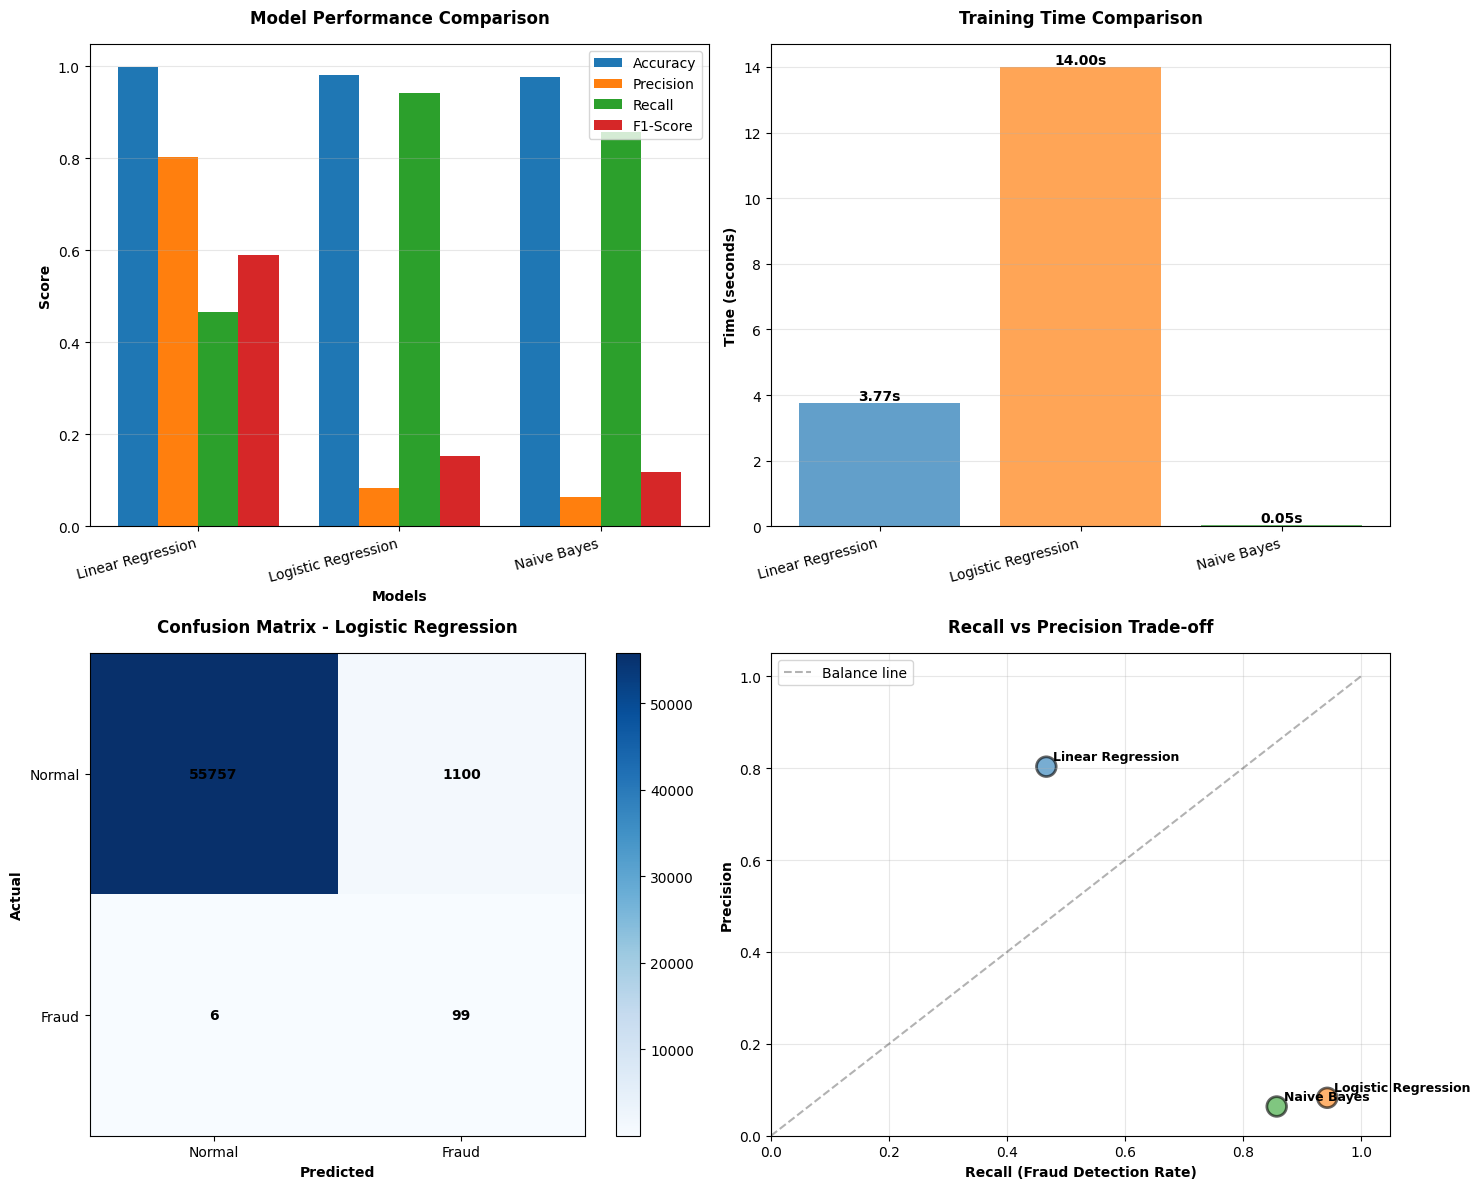

In [15]:
# Visualization of Model Performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Comparison - Bar Chart
ax1 = axes[0, 0]
metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
metrics_labels_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

x = np.arange(len(model_names))
width = 0.2

for i, (metric, label) in enumerate(zip(metrics_to_plot, metrics_labels_plot)):
    values = np.array([results[model][metric] for model in model_names])
    ax1.bar(x + i * width, values, width, label=label)

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Model Performance Comparison', fontweight='bold', pad=15)
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Training Time Comparison
ax2 = axes[0, 1]
train_times = np.array([results[model]['train_time'] for model in model_names])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax2.bar(model_names, train_times, color=colors, alpha=0.7)
ax2.set_ylabel('Time (seconds)', fontweight='bold')
ax2.set_title('Training Time Comparison', fontweight='bold', pad=15)
ax2.set_xticklabels(model_names, rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix Heatmap - Logistic Regression
ax3 = axes[1, 0]
cm_logistic = test_metrics_logistic['confusion_matrix']
im = ax3.imshow(cm_logistic, cmap='Blues', aspect='auto')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax3.text(j, i, cm_logistic[i, j],
                       ha="center", va="center", color="black", fontweight='bold')

ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Normal', 'Fraud'])
ax3.set_yticklabels(['Normal', 'Fraud'])
ax3.set_xlabel('Predicted', fontweight='bold')
ax3.set_ylabel('Actual', fontweight='bold')
ax3.set_title('Confusion Matrix - Logistic Regression', fontweight='bold', pad=15)
plt.colorbar(im, ax=ax3)

# 4. Recall vs Precision Trade-off
ax4 = axes[1, 1]
recalls = np.array([results[model]['test_recall'] for model in model_names])
precisions = np.array([results[model]['test_precision'] for model in model_names])

scatter = ax4.scatter(recalls, precisions, s=200, c=colors, alpha=0.6, edgecolors='black', linewidth=2)

for i, model in enumerate(model_names):
    ax4.annotate(model, (recalls[i], precisions[i]), 
                xytext=(5, 5), textcoords='offset points',
                fontweight='bold', fontsize=9)

ax4.set_xlabel('Recall (Fraud Detection Rate)', fontweight='bold')
ax4.set_ylabel('Precision', fontweight='bold')
ax4.set_title('Recall vs Precision Trade-off', fontweight='bold', pad=15)
ax4.grid(alpha=0.3)
ax4.set_xlim([0, 1.05])
ax4.set_ylim([0, 1.05])

# Add diagonal reference line
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Balance line')
ax4.legend()

plt.tight_layout()
plt.show()